In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import product
from utils import *
from models.models import *

In [2]:
ensure_reproducibility(42)

The analytical functions to regress and the activations that will be used

In [3]:
activations = ["relu", "tanh"]
analytic_functions = ["identity", "tanh", "sin", "square"]

Configuration for the extrapolation experiments

In [4]:
NUM_RUNS = 21
EPOCHS = 500
ARCHITECTURE = (1, 512, 1)

Regressing identity with relu activation
Regressing tanh with relu activation
Regressing sin with relu activation
Regressing square with relu activation
Regressing identity with tanh activation
Regressing tanh with tanh activation
Regressing sin with tanh activation
Regressing square with tanh activation


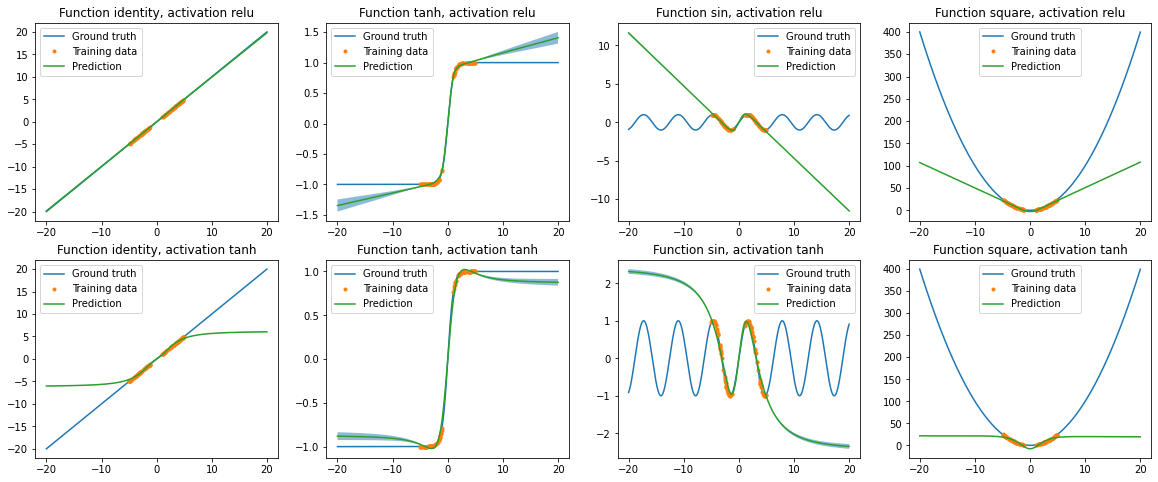

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=4)
fig.set_figheight(8)
fig.set_figwidth(20)

for i, activation in enumerate(activations):
    for j, function in enumerate(analytic_functions):

        print(f"Regressing {function} with {activation} activation")

        function_inputs, function_outputs = gen_func_dataset(lower_limit=-20, upper_limit=20, func=function)
        sample_inputs1, sample_outputs1 = sample_func_dataset(dataset_inputs=function_inputs, dataset_outputs=function_outputs, lower_lim=-5, upper_lim=-1, num_points=50)
        sample_inputs2, sample_outputs2 = sample_func_dataset(dataset_inputs=function_inputs, dataset_outputs=function_outputs, lower_lim=1, upper_lim=5, num_points=50)

        sample_inputs = torch.cat((sample_inputs1, sample_inputs2))
        sample_outputs = torch.cat((sample_outputs1, sample_outputs2))

        preds = []

        for run in range(NUM_RUNS):
            model = SimpleMLP(ARCHITECTURE, activation)

            model, _ = train_extrapolation(model, sample_inputs, sample_outputs, epochs=EPOCHS, verbose=False)
            with torch.no_grad():
                model.cpu()
                pred = model(function_inputs)
            preds.append(pred)

        preds = torch.stack(preds)

        preds_mean = torch.mean(preds, axis=0)
        preds_std = torch.std(preds, axis=0)
        preds_conf_interval = 1.64 * preds_std/math.sqrt(NUM_RUNS)

        ax[i, j].plot(function_inputs, function_outputs, label="Ground truth")
        ax[i, j].plot(sample_inputs, sample_outputs, '.', label="Training data")
        ax[i, j].plot(function_inputs, torch.mean(preds, axis=0), label="Prediction")
        ax[i, j].fill_between(function_inputs.numpy().squeeze(), (preds_mean-preds_conf_interval).numpy().squeeze(), (preds_mean+preds_conf_interval).numpy().squeeze(), alpha=0.5)
        ax[i, j].legend()
        ax[i, j].set_title(f"Function {function}, activation {activation}")